# Total Dataset mining

In [4]:
import pandas as pd 
import numpy as np
from datetime import date,datetime
import csv
import re
from multiprocessing import Pool
from functools import partial
from sklearn import preprocessing
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import itertools
import os
import json
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

In [5]:
# TODO add doc 
def dataset_property_split(df,frequency,properties,min_support,groupby_property="CUST_ID",itemset_property="ARTICLE_ID",temp_folder="../lcm_temp",indexation_folder="../index"):
    """Split dataset """
    for period,i in df.groupby(pd.Grouper(freq = frequency)):
        for values,ii in i.groupby(properties):
            if len(properties)>1:
                values = '_'.join(str(z) for z in values)
            
            split_name = f"{temp_folder}/{period}_{values}#{min_support}"
            index_file_name = f"{indexation_folder}/{period}_{values}#{min_support}"

            ii = ii.groupby(groupby_property)[itemset_property].apply(lambda x: " ".join(str(z) for z in x))
            
            ii.to_csv(split_name,index=None,header=False)
            pd.DataFrame(ii.index).to_csv(index_file_name,header=False,index=None)
            yield str(split_name)
        

def preprocessing_similar_ids(df,mapping_file_path="../datasets/Total/ids_mapping.json",attribute_name="ARTICLE_ID"):
    with open(mapping_file_path,"r") as f:
        mapping = json.load(f)
        ids = df[attribute_name].astype(str).replace(mapping)
    return ids
def reformat_output(unformated_result,split_name,index_folder="../index"):
    """
    Reformat default output of lcm  to a dataframe with structure : min_support,itemsets,users
    """
    output = pd.DataFrame([unformated_result[0::2],unformated_result[1::2]]).T
    output = pd.concat([output.drop(0,axis=1),output[0].str.split('\(([0-9]+)\)',expand=True).drop(0,axis=1)],axis=1)
    split_name= split_name.split("/")[2] #remove temp folder from name
    output["period"] = split_name.split("_")[0]
    output["property_values"] = "_".join(split_name.split("_")[1:]).split("#")[0]
    output.columns = ["CUST_ID","support","itemset","period","property_values"]
    indexes = pd.read_csv(f'{index_folder}/{split_name}',header=None)[0].to_dict()
    output["CUST_ID"]= output["CUST_ID"].map(lambda x : [indexes[int(i)] for i in x.split()])
    return output


# TODO doc for support
def run_lcm(split_name,itemsets_size,support,output_file):
    """Runs LCM (Single Thread)  and return the  result formated with format_output
    
    Example for parameters : input_file='1999',support=6, itemsets_size=[5,100]
    Executed command :  $ ./lcm C_QI -l 5 -u 100 1999 6 -
    
    Preconfigured parameters:  
     C: enumerate closed frequent itemsets
     M: enumerate maximal frequent itemsets 
     Q: output the frequency on the head of each itemset found,
     I: output ID's of transactions including each itemset; ID of a transaction is given by the number of line in which the transaction is written. The ID starts from 0.
     _: no output to standard output (including messages w.r.t. input data)
     -l,-u [num]: enumerate itemsets with size at least/most [num]  
   
    Output:
        Replace file having name input_file with the result : support,itemset,users
        if no itemset found the input_file is deleted and output is empty string ""
    """
    support = int(support)
    if None in itemsets_size:
        result = !./lcm C_QI -l {itemsets_size[0]} "{split_name}" {support} -
    else :
        result = !./lcm C_QI -l {itemsets_size[0]} -u {itemsets_size[1]}  "{split_name}" {support} -
    
    os.remove(split_name)
    if "there is no frequent item" in str(result) or result == []:
        print("No itemset",split_name)
        return 
    print("# LCM Found ",len(result)/2," in",split_name )
    # TODO Optimize this bottleneck 
    with open(output_file,"a+") as file:
        reformat_output(result,split_name).to_csv(file,header=False,index=None,mode="a")
    return split_name


def multithread_lcm(input_file,frequency,support,itemsets_size,properties,output_file):
    f = partial(run_lcm,itemsets_size=itemsets_size,support=support, output_file=output_file)
    p = Pool(1)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,support))
    p.close()
    p.join()
    return res
                                              
def linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties):
    output_file = f'../lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
    try:
        os.remove(output_file) # In case already existing
        print(f"Removed old {output_file}")
    except:
        print(f"No old file to remove for {output_file} ")
        pass
    a = multithread_lcm(df,frequency,min_support,itemsets_size,properties,output_file)
    total  = len(a._items)
    print(a,total)
    a = [i for i in a if i is not None]
    print(f"---| {output_file} Done")
    print(f'---| #split total: {total}')
    print(f'---| #split having groups: {len(a)}')
    print(f'---| Average: {len(a)/total}')
    print(" ")
    
    
def age_class(age):
    """User age to range classes """
    age = np.int(age)
    if age<=25:
        return 0
    if age<=45:
        return 1
    return 2
def prepare_data(file_name,folder_name="datasets/Total/data/"):
    df = pd.read_csv(f"datasets/Total/data/{file_name}",sep=";")
    df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    return df

def read_lcm_output_total(input_name,folder="../lcm_results"):
    """Read and restructure LCM output file,rename columns output a df """
    file = f'{folder}/{input_name}'
    df = pd.read_csv(file,header=None)
    df.columns = ["user_ids","support","itemsets","period","property_values"]
    df["period"] = pd.to_datetime(df["period"])
    df["user_ids"] = df.user_ids.apply(lambda x : [int(z.replace('"',"")) for z in x[1:-1].split(",") if z != ""])
    return df

### Run LCM

In [6]:
# frequencies =["M","2M","3M"]
# properties = [["STATION_MGT_TYPE"],["STATION_MGT_TYPE","DEPARTEMENT"]]
# from itertools import product
# for frequency,prop in product(frequencies,properties):
#     linear_closed_itemset_miner(df,frequency,5,[2,"5000"],prop)

## Dataset preprocessing 

In [7]:
import datetime
def concat_total_dataset(files_path='../datasets/Total/data'):
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
        break
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df

### Parameters for no demographics 

In [6]:
# Concat all total dataset 
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)

le = preprocessing.LabelEncoder()
df["ARTICLE_ID"] = le.fit_transform(df["ARTICLE_ID"]) 
df["a"] = 1 # Must set a "grouping" attribute while we don't consider demographics

In [6]:
df.TRANSACTION_DATE.min(),df.TRANSACTION_DATE.max()

('2018-04-01 01:38:56', '2018-06-30 22:40:01')

In [46]:
min_support = 2
frequency = 'M' # Time granularity could be D,3D,7D, M, 2M, Y, ...
min_description_size = 1 # the minimal number of products per group
itemsets_size = [1,None]
properties =["AGE"] # Set this to a groupping attribute, like ["sex","age"] or ["a"] to ignore this behaviour

In [47]:
linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties)
output_file = f'../lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
np.save(f'{output_file.replace("lcm_results/","plots/encoders/")}.npy', le.classes_)

No old file to remove for ../lcm_results/M-2-[1-None]-[AGE]-lcm.out 
Found  1.0  in ../lcm_temp/2017-02_35-49#2
No itemset ../lcm_temp/2017-02_50-65#2
No itemset ../lcm_temp/2017-02_<35#2
Found  281.0  in ../lcm_temp/2017-03_35-49#2
Found  212.0  in ../lcm_temp/2017-03_50-65#2
Found  73.0  in ../lcm_temp/2017-03_<35#2
Found  17.0  in ../lcm_temp/2017-03_>65#2
Found  352.0  in ../lcm_temp/2017-04_35-49#2
Found  287.0  in ../lcm_temp/2017-04_50-65#2
Found  93.0  in ../lcm_temp/2017-04_<35#2
Found  23.0  in ../lcm_temp/2017-04_>65#2
Found  449.0  in ../lcm_temp/2017-05_35-49#2
Found  311.0  in ../lcm_temp/2017-05_50-65#2
Found  109.0  in ../lcm_temp/2017-05_<35#2
Found  35.0  in ../lcm_temp/2017-05_>65#2
Found  439.0  in ../lcm_temp/2017-06_35-49#2
Found  268.0  in ../lcm_temp/2017-06_50-65#2
Found  115.0  in ../lcm_temp/2017-06_<35#2
Found  29.0  in ../lcm_temp/2017-06_>65#2
Found  582.0  in ../lcm_temp/2017-07_35-49#2
Found  442.0  in ../lcm_temp/2017-07_50-65#2
Found  172.0  in ../lcm_

In [13]:
output_file = f'../lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
# Here we fix a small issue with LCM, on total dataset products ids are too large, so we use a label encoder
# Once done, the encoder is saved and could be restored for post processing

np.save(f'{output_file.replace("lcm_results/","plots/encoders/")}.npy', le.classes_)
f'{output_file.replace("lcm_results/","plots/encoders/")}.npy'

'../plots/encoders/2M-3-[1-None]-[a]-lcm.out.npy'

In [58]:
# Extra step, inverse items encoding
result_df.itemsets= result_df.itemsets.apply(lambda x : le.inverse_transform([int(i) for i in x.split()]))

In [60]:
# Done :) 
result_df.to_csv(output_file)

# LCM on promotion periods

In [86]:
df.TRANSACTION_DATE.min(),df.TRANSACTION_DATE.max()

('2017-02-28 07:23:20', '2019-12-30 22:12:56')

In [87]:
# Global parameters
frequency ="9M"
min_support= 5
itemsets_size = [1,"2001"]
properties = ["firstpromo"]
file_name =f'{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
output_file = f'../lcm_results/{file_name}'

In [88]:
# Encoding for ARTICLE_ID as their size is not supported by current lcm implementation 
le = preprocessing.LabelEncoder()
le.fit(df["ARTICLE_ID"])
# # Encoder is saved 
np.save(f'../plots/encoders/{file_name}.npy', le.classes_)

In [89]:
# Promotion product list 
promo_products = pd.read_csv("../datasets/Total/promo_products.csv")
promo_products= promo_products[promo_products["ARTICLE_ID"].isin(df.ARTICLE_ID)]
promo_list = le.transform([i for i in promo_products.ARTICLE_ID.tolist()])

In [90]:
df["ARTICLE_ID"] = le.transform(df["ARTICLE_ID"])

In [91]:
# promo dates 
promo_date_begin = pd.to_datetime(datetime.date(2018,12,17))
promo_date_end = pd.to_datetime(datetime.date(2019,2,28))
print(promo_date_begin,promo_date_end)

# Transactions data for T-1, T and T+1
# T-1 = [promo_date_begin - 3 months , promo_date_begin] 
df_promo_before = df[(df['date']< promo_date_begin)& (df['date']>promo_date_begin + relativedelta(months=-3))]

# T = [promo_date_begin , promo_date_end] 
# Only promotion products are considered in T
df_promo = df[(df.date>= promo_date_begin)& (df.date<=promo_date_end)]
df_promo = df_promo[df_promo.ARTICLE_ID.isin(promo_list)]

# T+1 = [promo_date_end , promo_date_end + 3 months] 
df_promo_after = df[(df.date> promo_date_end)& (df.date<=promo_date_end + relativedelta(months=3))]

2018-12-17 00:00:00 2019-02-28 00:00:00


In [92]:
print(f"#trsansaction : \n Before promo {df_promo_before.shape[0]} \n During promo {df_promo.shape[0]} \n After promo {df_promo_after.shape[0]} " )

#trsansaction : 
 Before promo 19463 
 During promo 1887 
 After promo 19980 


# Only first product is the one in promotion 

In [93]:
df_promo.drop_duplicates("CUST_ID",inplace=True)

# Run LCM 

In [94]:
# os.remove(output_file)
f = partial(run_lcm,itemsets_size=itemsets_size,support=min_support, output_file=output_file)
for input_file in [df_promo_before,df_promo,df_promo_after]:
    input_file["firstpromo"]=1
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,min_support))
    p.close()
    p.join()

/home/abdelouahab/3env/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found  771.0  in ../lcm_temp/2018-09_1#5
Found  7.0  in ../lcm_temp/2018-12_1#5
Found  785.0  in ../lcm_temp/2019-02_1#5


# Promo period stats

,ARTICLE_ID
1,993
2,6
3,1


Text(0, 0.5, '# of users ')

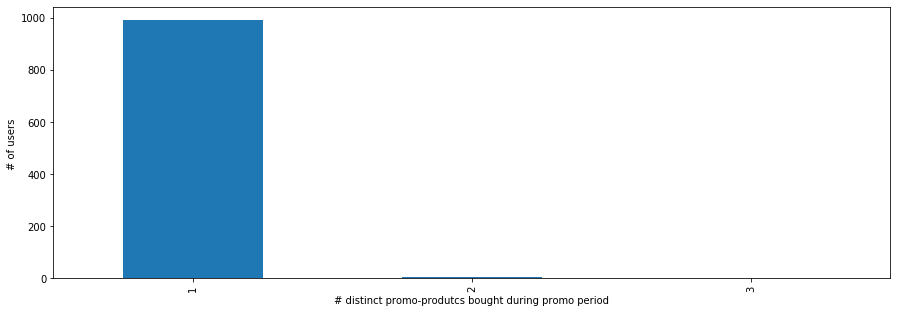

In [51]:
stats_df = df_promo.groupby("CUST_ID")["ARTICLE_ID"].apply(set).apply(len).to_frame().sort_values("ARTICLE_ID",ascending=False)["ARTICLE_ID"].value_counts()
ICD.display(stats_df.to_frame())

ax = stats_df.plot.bar(figsize=(15,5))
ax.set_xlabel("# distinct promo-produtcs bought during promo period")
ax.set_ylabel("# of users ")

In [55]:
stats_df = df_promo.groupby("ARTICLE_ID")["CUST_ID"].apply(list).apply(len).sort_values(0,ascending=False).to_frame().reset_index()

In [88]:
df_promo["ARTICLE_ID"]  = df_promo.apply(lambda x : le.inverse_transform([x.ARTICLE_ID])[0],axis=1)

Text(0, 0.5, '#Users')

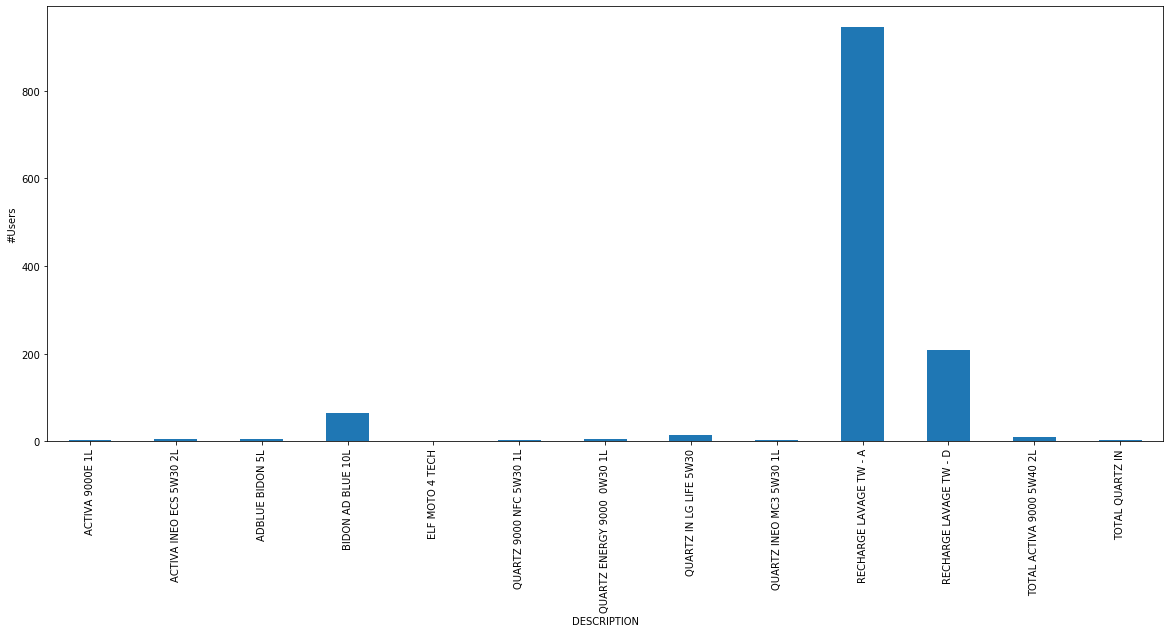

In [135]:
df_promo= df_promo.merge(items,on='ARTICLE_ID')
stats_df =  df_promo.groupby("DESCRIPTION").apply(len)
ax  = stats_df.plot.bar(figsize=(20,8),)
ax.set_xlabel("DESCRIPTION")
ax.set_ylabel("#Users")

In [141]:
stats_df= stats_df.sort_values("Users_Count",ascending=False)
stats_df.columns = ["DESCRIPTION", "Users_Count"]
stats_df

,DESCRIPTION,Users_Count
0,RECHARGE LAVAGE TW - A,946
1,RECHARGE LAVAGE TW - D,208
2,BIDON AD BLUE 10L,64
3,QUARTZ IN LG LIFE 5W30,14
4,TOTAL ACTIVA 9000 5W40 2L,10
5,ADBLUE BIDON 5L,6
6,QUARTZ ENERGY 9000 0W30 1L,4
7,ACTIVA INEO ECS 5W30 2L,4
8,QUARTZ INEO MC3 5W30 1L,3
9,QUARTZ 9000 NFC 5W30 1L,3


In [17]:
df.CUST_ID.nunique()

32160

In [8]:
items = pd.read_csv("../datasets/Total/items.csv",index_col=0)

In [65]:
ids = items.IDS_LIST.apply(lambda x : [int(i) for i in x[1:-1].split(',')]).sum()

# Draft

In [6]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from shutil import copyfile,copyfileobj
import pandas as pd
from IPython.core import display as ICD
from multiprocessing import Pool
import numpy as np
from datetime import timedelta
import re
import os
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
import plotly
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from itertools import groupby, product
import json
le = LabelEncoder()

def concat_total_dataset(files_path='../datasets/Total/data'):
    import datetime
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df

def run_lcm(split_name,itemsets_size,support,output_file,mode):
    """Runs LCM (Single Thread)  and return the  result formated with format_output
    
    Example for parameters : input_file='1999',support=6, itemsets_size=[5,100]
    Executed command :  $ ./lcm C_QI -l 5 -u 100 1999 6 -
    
    Preconfigured parameters:  
     C: enumerate closed frequent itemsets
     M: enumerate maximal frequent itemsets 
     Q: output the frequency on the head of each itemset found,
     I: output ID's of transactions including each itemset; ID of a transaction is given by the number of line in which the transaction is written. The ID starts from 0.
     _: no output to standard output (including messages w.r.t. input data)
     -l,-u [num]: enumerate itemsets with size at least/most [num]  
   
    Output:
        Replace file having name input_file with the result : support,itemset,users
        if no itemset found the input_file is deleted and output is empty string ""
    """
    support = int(support)
    if None in itemsets_size:
        result = !./lcm C_QI -l {itemsets_size[0]} "{split_name}" {support} -
    else :
        result = !./lcm C_QI -l {itemsets_size[0]} -u {itemsets_size[1]}  "{split_name}" {support} -
    
    if "there is no frequent item" in str(result) or result == []:
        print("No itemset",split_name)
        return False
    print("# LCM Found ",len(result)/2," in",split_name )
    # TODO Optimize this bottleneck 
    with open(output_file, mode) as file:
        reformat_output(result,split_name).to_csv(file,header=False,index=None,mode=mode)
    return split_name




def read_lcm_output_total(input_name,folder="../lcm_results"):
    """Read and restructure LCM output file,rename columns output a df """
    file = f'{folder}/{input_name}'
    df = pd.read_csv(file,header=None)
    df.columns = ["user_ids","support","itemsets","period","property_values"]
    df["period"] = pd.to_datetime(df["period"])
    df["user_ids"] = df.user_ids.apply(lambda x : [int(z.replace('"',"")) for z in x[1:-1].split(",") if z != ""])
    return df



def multiply_frequency(freq,times):
    unit,freq = re.findall("([0-9]+)([A-Z])",freq)[0]
    return f'{int(unit)*int(times)}{freq}'


def drop_old_files(input_name):
    """Drops previous lcm_result, group, links for for input name """
    for i in ["../plots/links/","../plots/groups/","../lcm_results/"]:
        try:
            file = i+input_name
            os.remove(file)
        except OSError as e :
            continue
def get_articles_descriptions(x,items,encoder):
    ee = encoder.inverse_transform([int(i) for i in str(x).split()])
    res = []
    for i in ee:
        if i in items.index:
            res.append(items.loc[i].DESCRIPTION)
        else:
            res.append(f"product-{i}")
    return res
def format_links(x):
    res = []
    for i in x[0]:
        for idx in range(len(i)-1):
            res.append([i[idx],i[idx+1],x["index"]])
    return res

def make_links(e,index):
    """Product of groups ids for each two consecutive groups periods"""
    prev = e[0]
    for i in e[1:]:
        yield from product(prev,i,[index])
        prev = i

def extract_demographics(input_file):
    demographics = re.findall("\[([A-Z|a-z|_]+),?([A-Z|a-z|_]+)?\]",input_file)[0]
    return  [i for i in demographics if i !=""]
def read_groups(file_name , groups_folder= "../plots/groups/"):
    groups = pd.read_csv(f"{groups_folder}{file_name}",index_col=0)
    groups.drop(["size","depth"],axis=1,inplace=True)
    groups["itemsets"] = groups["itemsets"].astype(str).apply(lambda x : [int(i) for i in x.split()])
    
    groups["user_ids"] = groups["user_ids"].apply(lambda x : [int(i) for i in x[1:-1].split(",")])
    groups["itemset_name"] = groups["itemset_name"].apply(lambda x : [i.strip() for i in x[1:-1].split(",")])
    
    return groups    
def process_lcm_result(input_file,stats_folder='../plots/stats',encoders_folder="../plots/encoders",links_folder="../plots/links",groups_folder='../plots/groups',users_demographics = ["DEPARTEMENT","SEX","AGE"],groups_demographics=["STATION_MGT_TYPE","DEPARTEMENT"],user_apparition_threshold=0,user_nunique_periods_threshold=1,keep_all_groups_in_periods=[]):
    # Initialisations 
    users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    groups_file = f'{groups_folder}/{input_file}'
    links_file = f'{links_folder}/{input_file}'
    demographics = extract_demographics(input_file)
    
    
    new_df = read_lcm_output_total(input_file)
    
    keep_only_users = frozenset(new_df.user_ids.sum())
    initial_processing = False
         
    try:# Adding old groups to df
        old = read_groups(output)
        # Index incrementation for new new groups to follow the old ones
        new_df.index+=old.shape[0]

        old = old[new_df.columns]
        old.itemsets = old.itemsets.apply(lambda x : ' '.join(str(i) for i in  x))
        old.period = pd.to_datetime(old.period)
        old = old[old.user_ids.apply(lambda x : bool(keep_only_users.intersection(x)))]
        
        df = pd.concat([old,new_df])
    except OSError as e :
        initial_processing = True
        df = new_df # No old file
        print("# ... Initial processing for ", input_file)

    mlb = MultiLabelBinarizer(sparse_output=True)
    _df = mlb.fit_transform(df.user_ids.tolist()).astype(bool)
    _df = pd.DataFrame(_df.toarray(),columns=mlb.classes_,index=df.index)[keep_only_users]
    
    # Thresholds for users filtering
    _df  = _df.T.apply(lambda x : df.index[np.where(x)[0]],axis=1)
    e = _df.to_frame()[0].apply(lambda x: list(list(z) for idx,z in groupby(x,lambda y: df.loc[y].period)))
    e = e[e.apply(lambda x:len(x))>user_nunique_periods_threshold]
    e = e.apply(lambda x : x[-2:]) # Keep only links having target groups in the latest period
     
    # Storing the links 
    res = []
    e.to_frame().reset_index().apply(lambda x: [res.append(i) for i in make_links(x[0],x["index"])],axis=1)
    if bool(res):
        links = pd.DataFrame(res)
        links.columns = ["source","target","user_id"]
    else: 
        links = pd.DataFrame(columns=["source","target","user_id"])
    links = links.groupby(["source","target"])["user_id"].apply(lambda x: ','.join(str(i) for i in x)).to_frame()

    # Storing the groups 
    # filter groups to the ones appearing in the links

    if initial_processing:
        df_groups = df
    else:
        df_groups = new_df
    # TODO : look for a label encoder that will normalize data by himself
    le.fit(df.period)
    df_groups['depth'] = le.transform(df_groups.period)/(df.period.nunique())
    df_groups['size'] = df_groups.user_ids.apply(len)
    
    if len(demographics)==1:
        df_groups[demographics[0]]= df_groups.property_values
    else:
        df_groups[demographics]= df_groups.property_values.str.split("_",expand=True)
    
    # Encoding items to their initial ID + adding names
    items = pd.read_csv("../datasets/Total/items.csv")
    encoder = LabelEncoder()
    encoder.classes_ = np.load(f'{encoders_folder}/15D-3-[2-5000]-[AGE]-lcm.out.npy')
    items = items.set_index("ARTICLE_ID")
    df_groups["itemset_name"] = df_groups["itemsets"].apply(lambda x : get_articles_descriptions(x,items,encoder))
    
    if initial_processing:
        # Store the links and groups
        df_groups.to_csv(groups_file)
        links.to_csv(links_file)
        
        # Keep a copy of groups and links 
        copyfile(links_file,f'{links_folder}/copy_links.csv',)
        copyfile(groups_file,f'{groups_folder}/copy_groups.csv')
    else:
        # Keep a copy of groups and links before adding new 
        copyfile(links_file,f'{links_folder}/copy_links.csv',)
        copyfile(groups_file,f'{groups_folder}/copy_groups.csv')
        # Append existing 
        df_groups.to_csv(groups_file,mode='a', header=False)
        links.to_csv(links_file,mode='a', header=False)

def drop_previous_changes(input_file,links_folder="../plots/links",groups_folder='../plots/groups'):
    groups_file = f'{groups_folder}/{input_file}'
    links_file = f'{links_folder}/{input_file}'
    
    copyfile(f'{links_folder}/copy_links.csv',links_file)
    copyfile(f'{groups_folder}/copy_groups.csv',groups_file)

def join_files(df, prev, new,freq):
    """ recreates concatenation of two splits """
    if prev is None or not bool(prev):
        print("Nothing to join")
        return new 
    date = prev[0].split("/")[-1].split("_")[0]
    date = datetime.strptime(date,"%Y-%m-%d").date()
    
    new_freq = multiply_frequency(freq,len(prev)+1)
    new_freq_days = int(new_freq.replace('D',""))
    
    df_ = df[pd.to_datetime(df.TRANSACTION_DATE).dt.date>= date]
    df_ = df_[pd.to_datetime(df_.TRANSACTION_DATE).dt.date< date+timedelta(days=new_freq_days)]
    print("Join files new frequency : ",new_freq)
    result = [i for i in dataset_property_split(df_,new_freq,properties,min_support)]

    if len(result)>1:
        raise Exception("Should find only one result not 2 ")
    return result[0]

def splited_links(file_name):
    links = pd.read_csv(f"../plots/links/{file_name}")
    groups = read_groups(file_name)[["period","itemset_name","itemsets"]]
    links = links.merge(groups,left_on="source",right_index=True).merge(groups,left_on="target",right_index=True)
    links.user_id = links.user_id.apply(lambda x : list(x.split(","))) 
    links.period_y= pd.to_datetime(links.period_y).dt.date
    links.period_x= pd.to_datetime(links.period_x).dt.date
    return links
def interest_gain(x,product_id,target_users,links):
    users = target_users.intersection(x["user_id"])
    period  = x["period_x"]                                                      
      
    if product_id not in x["itemsets_y"] or users==set():
        
        return [False]
    output = []
    for user in users:
        res = links[links.apply(lambda x : user in x["user_id"] and period==x["period_x"],axis=1)]["itemsets_x"].sum()
        if res ==0:
            res = [0]
        output.append(product_id not in res)
    return output

def validation_function(file,threshold):

    copyfile("../plots/html/model_plot.html",f"../plots/html/{file.replace('out','')}html")
    
    links = splited_links(output)
    links = links[links.period_y==links.period_y.max()]
    links = links[links.user_id.apply(lambda x : any(i in x for i in target_users))]
    links.period_y= pd.to_datetime(links.period_y).dt.date
    # links.groupby("period")["user_id"].plot.bar()
    # Interest gain query 
    links["interest_gain"] = 0
    links["interest_gain"] = links.apply(lambda x : interest_gain(x,product_id,target_users,links),axis=1)
    links["interest_gain"] = links["interest_gain"].apply(lambda x : len([i for i in x if i is True]) )
    ICD.display(links)
    print(links.interest_gain.max(),threshold,links.interest_gain.max()>threshold)
    return links.interest_gain.max()>threshold

In [7]:
# Concat all total dataset 
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)

le = preprocessing.LabelEncoder()
df["ARTICLE_ID"] = le.fit_transform(df["ARTICLE_ID"]) 
df["a"] = 1 # Must set a "grouping" attribute while we don't consider demographics

df_copy = df.copy()
df_copy = df_copy[df_copy.SEX=="M"]

In [8]:
df_copy = df_copy[pd.to_datetime(df_copy.TRANSACTION_DATE).dt.date>datetime(2017,12,31).date()]
df_copy = df_copy[pd.to_datetime(df_copy.TRANSACTION_DATE).dt.date<datetime(2019,1,1).date()]
df_copy.index.min(),df_copy.index.max()

(Period('2018-01-01', 'D'), Period('2018-12-30', 'D'))

### Parameters

In [9]:
# # Running the Interest gain query 
target_users = set([str(i) for i in[235297,127790,1166148,1168767,612824,156634,114666,739860,607784,1171591,118478,616689,427250,133892,1198352,421137,205109,1166148,1167207,1168767,270220,368080,612824,156634,751640,751640,483533,1163691,612824,739860,838190,1061637,127790,1166148,156634,314647,187833,464331,133070,114666,403445,1061637,127790,1166148,156634,314647,187833,464331,133070,114666,403445,1061637,127790,1166148,156634,314647,187833,464331,133070,114666,403445,1061637,127790,1166148,156634,314647,187833,464331,133070,114666,403445]])
print(len(target_users))
product_id, product_name  = "1538","Recharge cafe club"
# product_id, product_name  = "4125","Recharge Lavage TW A"
# product_id, product_name  = 4112,"Reharge CLU"
# product_id, product_name  = 4074,"Bidon Ad Blue 10L  "
# product_id, product_name  = 2297,"COCA COLA"
drift_name = "interest_gain"

30


In [10]:
frequency = "7D"
min_support = 30
itemsets_size= [1,10]
properties = ["SEX"]
## 
output = f'{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
output_file = f'../lcm_results/{output}'

# Sliding window with LCM

In [11]:
df = df_copy.copy()
drop_old_files(output)

prev = []
cpt = 0
mode = "w"

for split_name in dataset_property_split(df,frequency,properties,min_support):
    continue
    print("Processing split",split_name)
    result = run_lcm(split_name,itemsets_size,min_support,output_file,mode)
    if result:
        cpt+=1
    else:
        continue
    if cpt ==1 : # NO check when there is less than 2 periods
        prev = []
        mode = "a"
        continue
    mode = 'w'
    process_lcm_result(output)
    if True: # Drfit found save current groups
        # Clear LCM output 
        mode = 'w'
        prev = [split_name]
    else: # No drift found, must get the next split and recompute groups
        # cancel previous groups and links addition
        drop_previous_changes(output)
        
        i = join_files(df,prev,split_name,frequency)
        print("#  Reprocessing",i,len(prev))
        run_lcm(i,itemsets_size,min_support*len(prev),output_file,"w")
        process_lcm_result(output)
        prev.append(split_name)
copyfile("../plots/html/model_plot.html",f"../plots/html/{output.replace('out','')}html")


'../plots/html/7D-30-[1-10]-[SEX]-lcm.html'

### Running query

In [12]:
links = splited_links(output)
links = links[links.user_id.apply(lambda x : any(i in x for i in target_users))]
links.period_y= pd.to_datetime(links.period_y).dt.week
links["interest_gain"] = 0
links["interest_gain"] = links.apply(lambda x : interest_gain(x,1538,target_users,links),axis=1)
links["interest_gain"] = links["interest_gain"].apply(lambda x : len([i for i in x if i==True]))

FileNotFoundError: [Errno 2] File ../plots/links/7D-30-[1-10]-[SEX]-lcm.out does not exist: '../plots/links/7D-30-[1-10]-[SEX]-lcm.out'

### Lcm with no sliding window plot 

In [13]:
plt.style.use('default')

def plot_query_results(links,drift_name,stacked=True):
    stats_df = links.groupby(["period_y"])[drift_name].value_counts().unstack()
    ax= stats_df[stats_df.columns[1:]].dropna(how='all').plot.bar(stacked=stacked,figsize=(30,6))
    ax.set_xlabel("Weeks from 2018-2019")
    ax.set_ylabel("Number of subsets")
    plt.rcParams.update({'font.size': 12})
    plt.title(f"Figure 1: For every week from 2018 to 2019 multiple subsets of C satisfy {drift_name} for {product_name}, the {drift_name} values are counted in the following stacked bar plot")
    return ax
plot_query_results(links,drift_name)
plt.show()

NameError: name 'links' is not defined

### 2.1 Raw data Sliding window + Fixed window

In [14]:
# fitler data on product p and users in target users 
df = df_copy.copy()
df_ = df[(df.ARTICLE_ID.astype(str)==product_id)&(df.CUST_ID.isin([int(i) for i in target_users]))]
df_.index = pd.DatetimeIndex(pd.to_datetime(df_.TRANSACTION_DATE).dt.date)

res,drifts = [],[]
stats = pd.DataFrame()
stats2 = pd.DataFrame()
threshold = 5
prev_drift = set()
res2= []
frequencies = ["1W","2W","3W","4W"]

for frequency in frequencies:
    customers,cpt,res = set(),0,[]
    indexer = pd.date_range(start = df_.index.min().date(), end = df_.index.max().date(), freq = frequency)

    splits = df_.groupby(pd.Grouper(freq=frequency)).CUST_ID.unique().reindex(indexer,fill_value=[])
#     splits = df_.groupby(pd.Grouper(freq=frequency)).CUST_ID.unique()
    prev = splits.iloc[0]
    
    for idx,i in splits.to_frame().iloc[1:].iterrows():
        customers = customers.union(i.CUST_ID)
        drift = customers.difference(prev)
        res2.append((idx,len(drift),drift.difference(prev_drift)))
        if len(drift) >threshold: # Drift found 
            prev = customers
            customers = set()
            prev_drift = set()
        res.append((idx,len(drift),drift))
        
        prev_drift = prev_drift.union(drift)
    a = pd.DataFrame(res,columns=["period_y",drift_name,"customers"])
    a = a.set_index("period_y")
    a["granularity"] = frequency
    stats = pd.concat([stats,a])
    
    # Optional part
    aa = pd.DataFrame(res2,columns=["period_y",drift_name,"customers"])
    aa = aa.set_index("period_y")
    aa["granularity"] = frequency
    stats2 = pd.concat([stats2,aa])

    
details = stats.copy()
threshold_points = stats.copy()
threshold_points.index = threshold_points.index.week
threshold_points = threshold_points[threshold_points[drift_name]>threshold]
threshold_points = threshold_points.pivot(columns='granularity',values=drift_name)
threshold_points = threshold_points.stack().to_frame().reset_index().set_index("period_y")
threshold_points.columns = ["granularity",drift_name]

## No sliding windows plot 

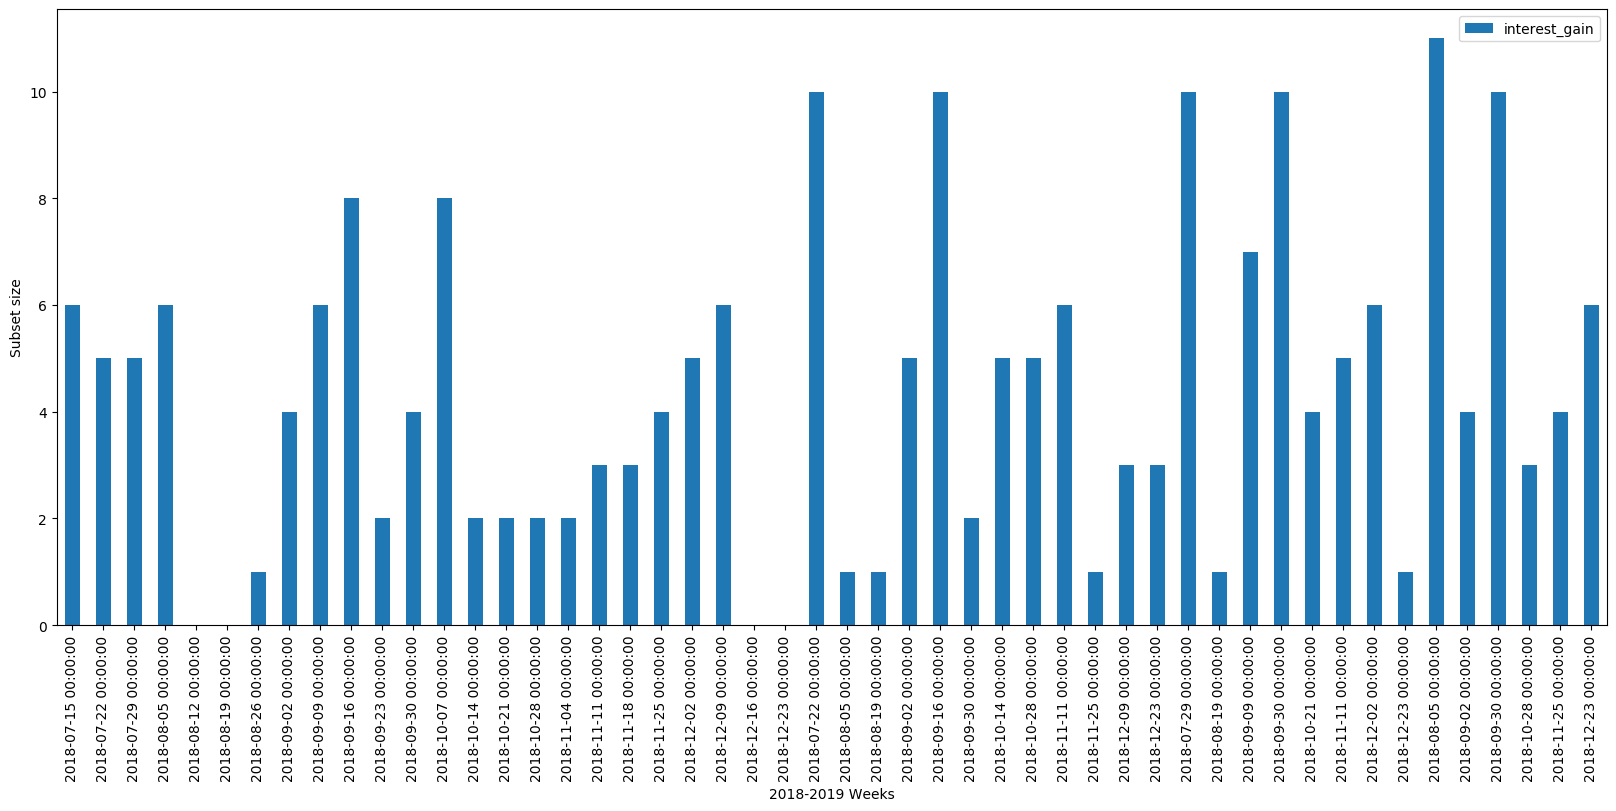

In [15]:
plt.style.use('default')
ax = stats.plot.bar(figsize=(20,8))
ax.set_ylabel("Subset size")
ax.set_xlabel("2018-2019 Weeks")
plt.show()

## 2.2 Sliding windows plot 

In [16]:
index = stats.index
res  = []
cpt==0
for i in stats.index:
    if i in stats[stats[drift_name]>threshold].index :
        res.append(i)
        continue
    res.append("")
res[0], res[-1] = index[0],index[-1]

columns = stats.granularity.unique()
stats.index = stats.reset_index().period_y.dt.week
stats = stats.reset_index().pivot(index="period_y",values=drift_name,columns="granularity").fillna(method="ffill")
stats.loc[stats.index.min()-1] = [0]*len(frequencies)
stats.sort_index(inplace=True)
stats = stats.fillna(0)

granularity,1W,2W,3W,4W
period_y,,,,
27,[],[],[],[]
28,"[7, 17, 19, 25, 27, 28]",[],[],[]
29,"[16, 18, 21, 22, 24]","[7, 16, 17, 18, 19, 21, 22, 25, 27, 28]",[],[]
30,"[16, 18, 21, 22, 24]",[],"[7, 16, 17, 18, 19, 21, 22, 25, 27, 28]",[]
31,"[15, 16, 18, 21, 22, 24]",[15],[],"[7, 15, 16, 17, 18, 19, 21, 22, 25, 27, 28]"
32,[],[],[],[]
33,[],[15],[15],[]
34,[5],[],[],[]
35,"[1, 2, 5, 6]","[1, 2, 5, 6, 15]",[],"[1, 2, 5, 6]"


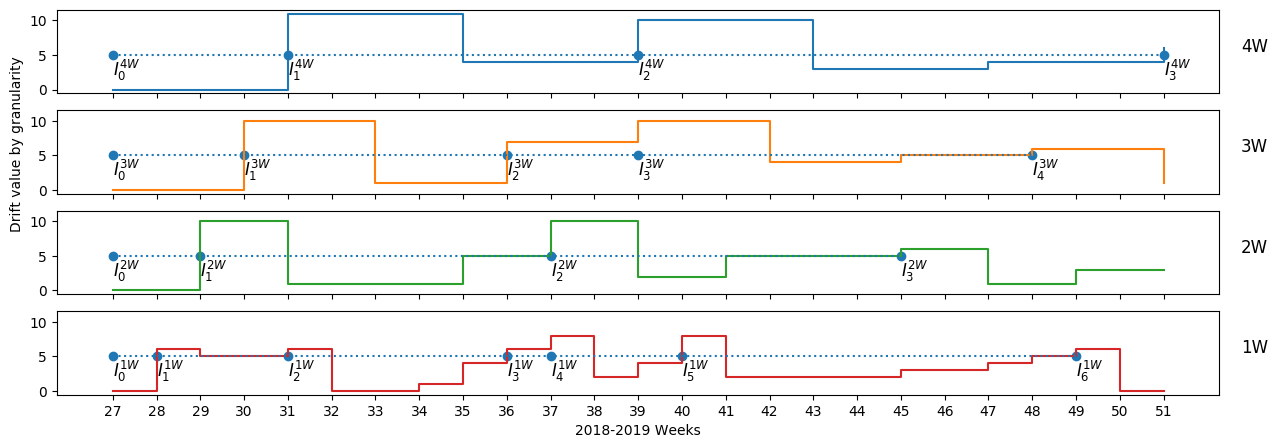

In [24]:
fig, axs = plt.subplots(len(stats.columns), sharex=True, sharey=True,figsize=(15,5))
fig.suptitle('',y=1.1)
for idx,i in enumerate(sorted(stats.columns,reverse=True)):
    axs[idx].plot(stats.index,stats[i],drawstyle='steps-post',c=f"C{idx}")
    axs[idx].set_xticks(stats.index.unique())
#     axs[idx].grid(axis="y")
#     axs[idx].grid(axis="x")
    axs[idx].set_xticklabels(stats.index.unique())
    axs[idx].set_title(i,x=1.03,y=0.4)
    # Drift points indicator
    threshold_indicator = threshold_points[threshold_points.granularity==i][drift_name].copy()
    threshold_indicator.loc[stats.index.min()]= threshold
    threshold_indicator.sort_index(inplace=True)
    # add drift points to plot 
    axs[idx].scatter(threshold_indicator.index,[threshold]*threshold_indicator.shape[0])
    axs[idx].plot(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],':')

    for idxx,ii in enumerate(threshold_indicator.index.fillna(stats.index.min())):
        axs[idx].text(ii,threshold-3,"$I_{}^{{{}}}$".format(idxx,i),fontsize=12)
    
axs[idx].set_xlabel('2018-2019 Weeks')
axs[idx].set_ylabel('Drift value by granularity',y=idx)
# fig.tight_layout(pad=0.3)
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(target_users))
a = details.copy()
a.customers = details.customers.apply(lambda x :sorted(le.transform(list(x))))
a = a.reset_index().pivot(index="period_y",values='customers',columns="granularity").fillna(value='[]')
a.index = a.index.week
a.loc[27] = [[],[],[],[]]
a.sort_index(inplace=True)
a.style.apply(lambda x: ['background: lightblue' if len(i)>threshold else '' for i in x ],axis=0)

granularity,1W,2W,3W,4W
period_y,,,,
27,[],[],[],[]
28,"[7, 17, 19, 25, 27, 28]",[],[],[]
29,"[16, 18, 21, 22, 24]","[7, 16, 17, 18, 19, 21, 22, 25, 27, 28]",[],[]
30,"[16, 18, 21, 22, 24]",[],"[7, 16, 17, 18, 19, 21, 22, 25, 27, 28]",[]
31,"[15, 16, 18, 21, 22, 24]",[15],[],"[7, 15, 16, 17, 18, 19, 21, 22, 25, 27, 28]"
32,[],[],[],[]
33,[],[15],[15],[]
34,[5],[],[],[]
35,"[1, 2, 5, 6]","[1, 2, 5, 6, 15]",[],"[1, 2, 5, 6]"


In [20]:

##### pd.options.display.max_colwidth = 100
frequency ="W"
indexer = pd.date_range(start = df_.index.min().date(), end = df_.index.max().date(), freq = frequency)

splits = df_.groupby(pd.Grouper(freq=frequency)).CUST_ID.unique().reindex(indexer,fill_value=[])

a= splits.to_frame()
a.CUST_ID  = a.CUST_ID.apply(lambda x : sorted(le.transform(x)))
a.index = pd.to_datetime(a.reset_index()["index"]).dt.week
a

,CUST_ID
index,
27,"[1, 13, 24, 26]"
28,"[7, 13, 17, 19, 25, 26, 27, 28]"
29,"[13, 16, 17, 18, 19, 21, 22, 24, 28]"
30,"[7, 17, 21, 28]"
31,"[7, 15, 21]"
32,[]
33,[]
34,"[5, 13, 17]"
35,"[1, 2, 6, 7, 13, 21, 28]"


In [21]:
indexer = pd.date_range(start = df_.index.min().date(), end = df_.index.max().date(), freq = "1W")

splits = df_.groupby(pd.Grouper(freq="W")).CUST_ID.unique().reindex(indexer,fill_value=[])
splits.index = splits.index.week

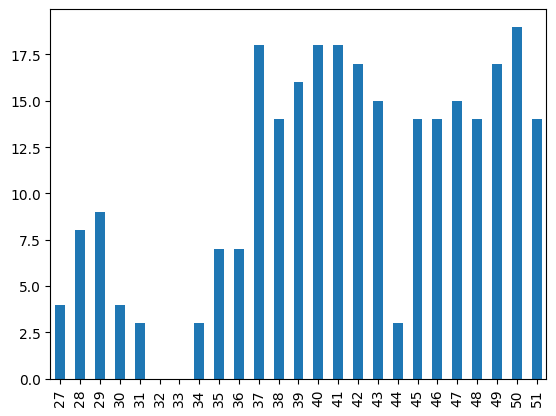

In [22]:
a = splits.apply(len)
a.plot.bar()

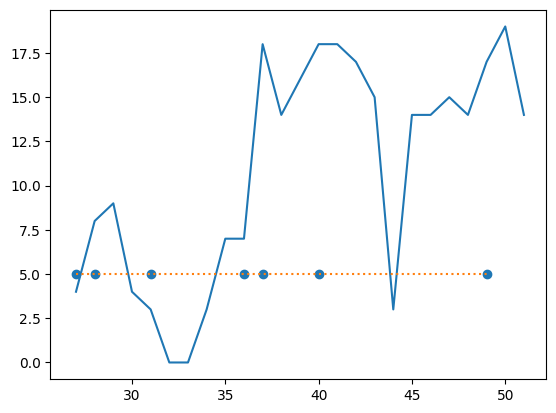

In [75]:
ax = a.plot.line(grid=True)
threshold = 5
threshold_indicator = threshold_points[threshold_points.granularity=="1W"][drift_name].copy()
threshold_indicator.loc[stats.index.min()]= threshold
threshold_indicator.sort_index(inplace=True)
# add drift points to plot 
ax.scatter(threshold_indicator.index,[threshold]*threshold_indicator.shape[0])
ax.plot(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],':')
ax.grid(axis="x")
ax.grid(axis="y")

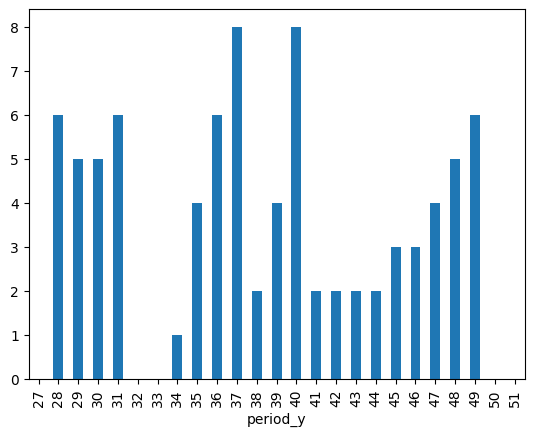

In [83]:
a["1W"].apply(len).plot.bar()

In [79]:
users = pd.read_csv("../datasets/Total/users.csv",sep=";")
users

,CUST_ID,SEX,AGE,DEPARTEMENT
0,1058702,M,<35,31
1,1006799,M,<35,77
2,1203632,M,<35,31
3,619087,M,<35,39
4,1217481,F,<35,37
...,...,...,...,...
1140756,1095071,M,<35,31
1140757,975892,M,<35,94
1140758,437500,M,<35,33
1140759,1092708,M,<35,50


6


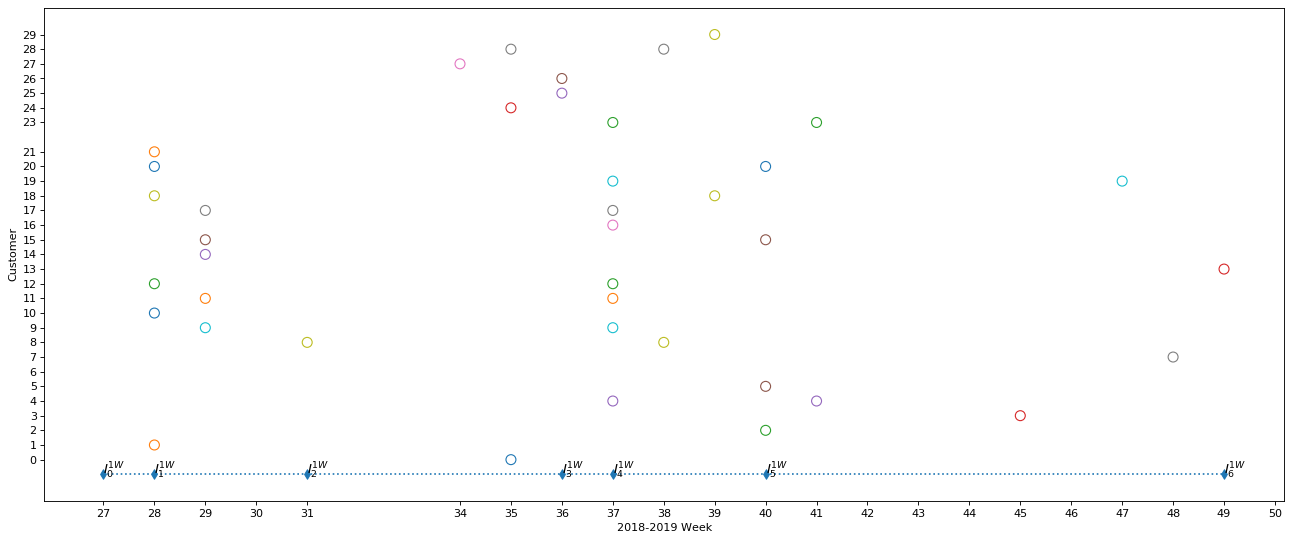

In [350]:
a = df_[df_.CUST_ID.isin(target_users)]
le.fit([ int(i) for i in target_users])
a.CUST_ID = le.transform(df_.CUST_ID)
a.TRANSACTION_DATE = pd.to_datetime(a.TRANSACTION_DATE).dt.date
a = a.groupby(["CUST_ID",pd.Grouper(freq="1W")]).ARTICLE_ID.apply(set).apply(lambda x: int(int(product_id) in x))
a = a.reset_index().pivot(index="TRANSACTION_DATE",values="ARTICLE_ID",columns="CUST_ID")
plt.figure(figsize=(20, 8), dpi=80)
ax = plt.subplot(1,1,1)
a.index = a.index.week
for idx,i in enumerate(a.columns):
    index = a[a[i]==True].index
    values = [i]*index.shape[0]
#     ax.scatter(x=index,y=values,color = f'C{idx}')
#     ax.scatter(x=index,y=values,color = f'C{idx}')
    try:
        index = drift_points[drift_points[i]==1].index
    except Exception as e:
        print(e)
        continue
    values = [i]*index.shape[0]
    ax.scatter(x=index,y=values, s=80, facecolors='none', edgecolors=f'C{idx}')
ax.set_yticks(a.columns.unique())
ax.set_xticks(a.index.unique())
ax.set_xlabel("2018-2019 Week")
ax.set_ylabel("Customer")

threshold = -1
threshold_indicator = threshold_points[threshold_points.granularity=="1W"][drift_name].copy()
threshold_indicator.loc[stats.index.min()]= threshold
threshold_indicator.sort_index(inplace=True)
# add drift points to plot 
ax.scatter(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],marker="d")
ax.plot(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],':')
for idxx,ii in enumerate(threshold_indicator.index.fillna(stats.index.min())):
    ax.text(ii,-1,"$I_{}^{{{}}}$".format(idxx,"1W"),fontsize=12)
    
# plt.plot()

In [322]:
res =  []
details = stats2.copy()
details[details.granularity=="1W"].reset_index().apply(lambda x:[res.append((x["period_y"],i,x["granularity"])) for i in x['customers']],axis=1)
res = pd.DataFrame(res,columns=["index","customer","granularity"])
res["values"] = 1
res.customer = le.transform(res.customer)
drift_points = res.pivot(index="index",columns="customer",values='values')
drift_points.index = pd.to_datetime(drift_points.index).week

In [321]:
res1 = res.copy()

In [326]:
draw = pd.concat([res,res1])

AttributeError: 'PathCollection' object has no attribute 'scatter'

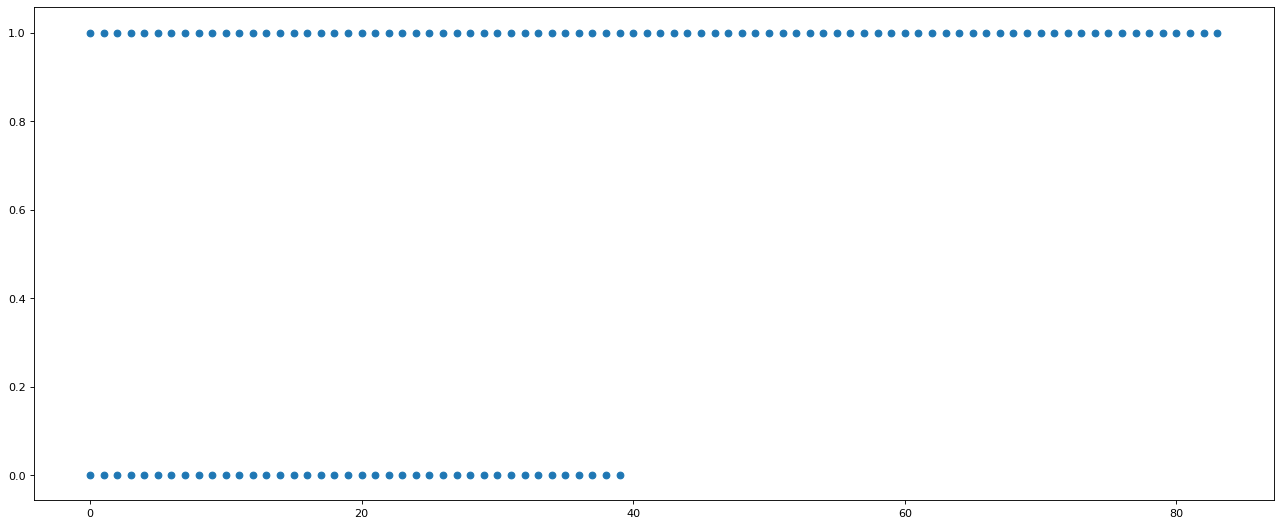

In [345]:
plt.figure(figsize=(20, 8), dpi=80)
ax = plt.scatter(draw[["values","index"]].index,draw["values"])
threshold = -1
threshold_indicator = threshold_points[threshold_points.granularity=="1W"][drift_name].copy()
threshold_indicator.loc[stats.index.min()]= threshold
threshold_indicator.sort_index(inplace=True)
# add drift points to plot 
ax.scatter(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],marker="d")
ax.plot(threshold_indicator.index,[threshold]*threshold_indicator.shape[0],':')

In [344]:
ax